<a href="https://colab.research.google.com/github/Mollylst/DeepFake-Project/blob/main/VGG16_FFHQ_stylegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train-fake-stylegan1.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train_real.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/test-fake-stylegan1.zip' -d /content/test
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/test_real.zip' -d /content/test

In [ ]:
import torch
import torchvision
import os
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data import random_split

#prepare dataset and preprocessing
data_dir='/content/dataset'

transform_train = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5184, 0.4233, 0.3776], [0.2795, 0.2535, 0.2548]))
])

transform_test = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize([0.5184, 0.4233, 0.3776], [0.2795, 0.2535, 0.2548]))
])

batch_size = 128

trainset_total = datasets.ImageFolder(data_dir+'/train',transform=transform_train)

trainset,validset=random_split(trainset_total,[16000,2000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = datasets.ImageFolder(data_dir+'/test',transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x)) for x in ['train', 'test']}
classes = image_datasets['train'].classes
print(classes)
#classes = ('fake', 'real')

['fake', 'real']


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
def save_checkpoint(state, filename="./drive/MyDrive/vgg16-FFHQ-stylegan-my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, net, optimizer):
    print("=> Loading checkpoint")
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
from torchvision import models
import torch.nn as nn
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(    
                nn.Linear(512 * 7 * 7, 8192),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(8192, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, 2048),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(2048, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        
net=VGGNet().to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0, last_epoch=-1, verbose=False)


#load_checkpoint(torch.load("my_checkpoint.pth.tar"), net, optimizer)

Epoch: 1/50
Epoch: 001, Training: Loss: 0.6933, Accuracy: 50.7313%, 
		Validation: Loss: 0.6939, Accuracy: 50.1500%, Time: 70.1137s
Best Accuracy for validation : 0.5015 at epoch 001
Epoch: 2/50
Epoch: 002, Training: Loss: 0.6873, Accuracy: 54.0875%, 
		Validation: Loss: 0.6955, Accuracy: 49.8500%, Time: 65.5088s
Best Accuracy for validation : 0.5015 at epoch 001
Epoch: 3/50
Epoch: 003, Training: Loss: 0.6763, Accuracy: 56.8063%, 
		Validation: Loss: 0.6382, Accuracy: 63.5000%, Time: 70.4005s
Best Accuracy for validation : 0.6350 at epoch 003
Epoch: 4/50
Epoch: 004, Training: Loss: 0.6302, Accuracy: 64.5312%, 
		Validation: Loss: 0.5309, Accuracy: 75.4000%, Time: 70.4659s
Best Accuracy for validation : 0.7540 at epoch 004
Epoch: 5/50
Epoch: 005, Training: Loss: 0.5570, Accuracy: 71.9000%, 
		Validation: Loss: 0.4313, Accuracy: 81.5000%, Time: 70.2744s
Best Accuracy for validation : 0.8150 at epoch 005
Epoch: 6/50
Epoch: 006, Training: Loss: 0.4231, Accuracy: 80.7938%, 
		Validation: Lo

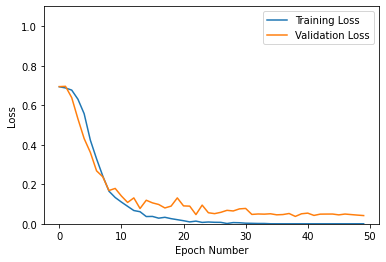

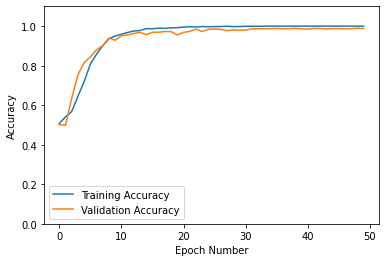

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

num_epoch=50
path='./drive/MyDrive/vgg16-FFHQ-stylegan.pth'

def train_and_valid():
    history = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))
        
        # Try save checkpoint
        if epoch==49:
          checkpoint = {"state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
          save_checkpoint(checkpoint)

        net.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs, labels = inputs.to(device), labels.to(device)
 
            #the gradient is increasing, so make it zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        #validation
        net.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(validloader):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _,predictions = torch.max(outputs.data, 1)
                #total += labels.size(0)
                valid_acc += (predictions == labels).sum().item()
 
        avg_train_loss = train_loss/ len(trainset)
        avg_train_acc = train_acc/ len(trainset)
 
        avg_valid_loss = valid_loss/ len(validset)
        avg_valid_acc = valid_acc/ len(validset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(net.state_dict(),path)
        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
          
    return history
    
#start training and testing
history = train_and_valid()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


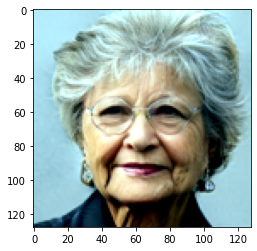

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


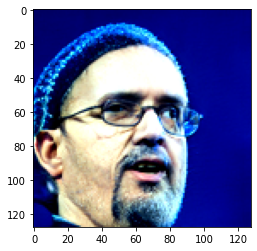

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


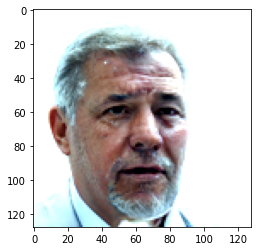

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


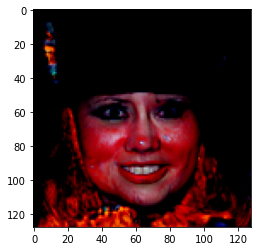

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


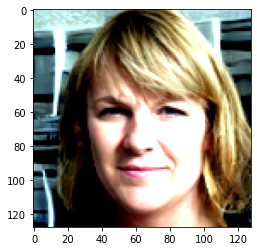

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


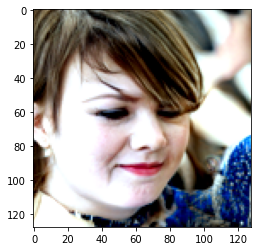

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


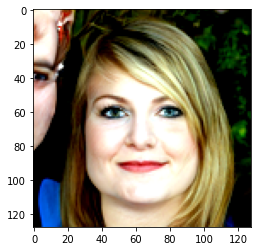

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


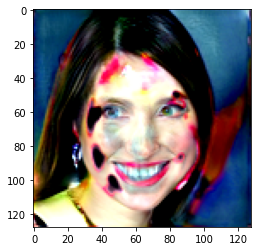

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


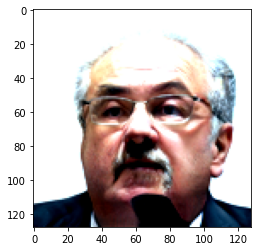

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


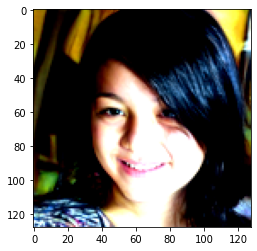

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


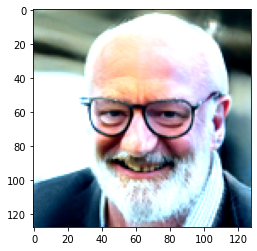

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


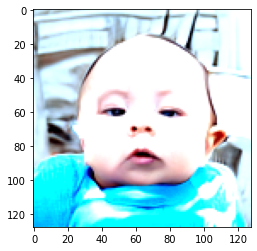

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


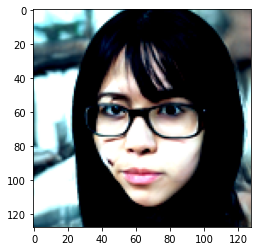

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


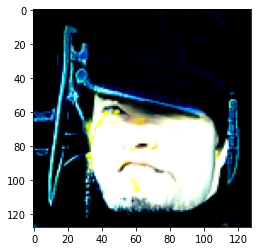

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


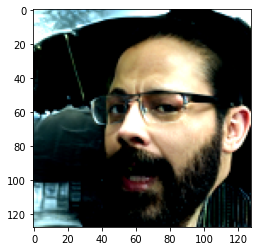

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


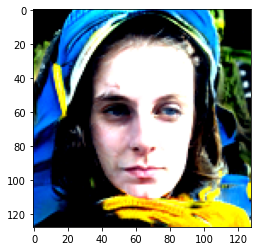

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


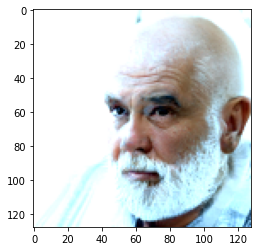

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


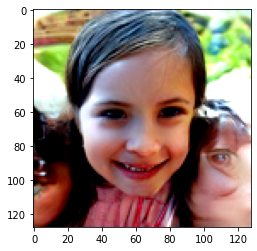

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


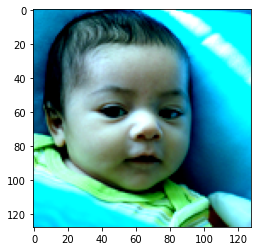

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  fake   GroundTruth:  real


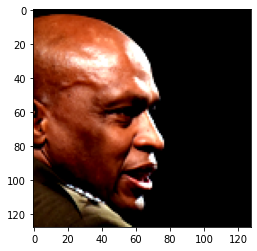

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  fake   GroundTruth:  real


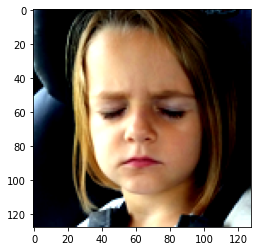

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  fake   GroundTruth:  real


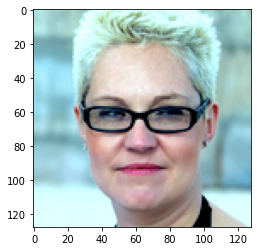

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  fake   GroundTruth:  real


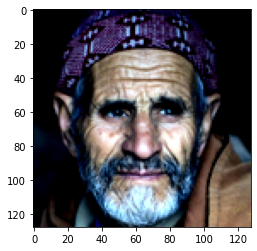

Predicted:  fake   GroundTruth:  real


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


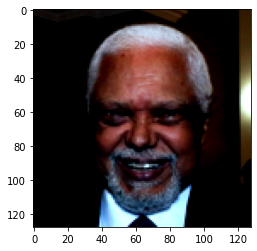

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  fake   GroundTruth:  real


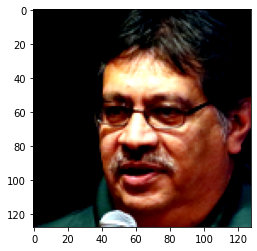

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  fake   GroundTruth:  real


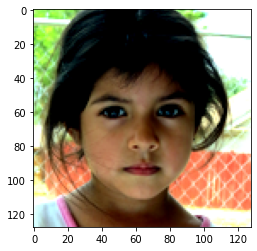

Predicted:  fake   GroundTruth:  real
Accuracy of the network on the test images: 98.700 %


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

path='./drive/MyDrive/vgg16-FFHQ-stylegan.pth'
net.load_state_dict(torch.load(path))
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
correct = 0
total = 0
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(len(inputs)):
          if classes[predicted[i]] != classes[labels[i]]:
            w_images = inputs[i].cpu()
            imshow(w_images)
            print('Predicted:', ''.join('%5s' % classes[predicted[i]] ),'  GroundTruth:',''.join('%5s' % classes[labels[i]]))

print('Accuracy of the network on the test images: %.3f %%' % (
    100 * correct / total))